# Sujet 7 : Classer les réponses du Grand Débat dans des catégories prédéfinies

Au cours du premier trimestre 2019 s'est tenu un "grand débat national" en France. Quatre thèmes étaient proposés par le gouvernement : transition écologique, fiscalité et dépenses publiques, démocratie et citoyenneté, organisation de l'état et des services publics. Ce débat a pris plusieurs formes, mais l'une d'elle était la possibilité de donner son avis via l'utilisation d'un formulaire Internet. Une contribution consiste en une succession de réponses à des questions ouvertes et fermées sur l'une des quatre thématiques proposées.

Ce sujet consiste à classer les contributions dans des catégories prédéfinies. Deux tâches sont proposées :
- reclasser l'ensemble des contributions dans les 4 grands thèmes à partir du texte des réponses
- classer les réponses à une question en lien avec l'environnement dans des domaines préétablis

Les données sont issues de deux sources : 
- Le [site du Grand Débat National](https://granddebat.fr/pages/donnees-ouvertes) permet de télécharger l'ensemble des contributions. Il est également possible de les consulter directement sur le site, [ici](https://granddebat.fr/pages/consulter-les-propositions).
- L'initiative [La Grande Annotation](https://grandeannotation.fr/) permet d'obtenir pour la plupart des questions ouvertes du Grand Débat des réponses classées dans des catégories. Plus de 1000 personnes ont lu et annoté des contributions pour les classer.

L'approche proposée ici est celle du _word embedding_. Elle consiste à associer à chaque mot un vecteur numérique (pour le rendre compréhensible par une machine), de façon à ce que deux mots proches sémantiquement possèdent des vecteurs proches numériquement. Pour ce faire, nous allons utiliser la librairie fastText.

### Import des packages

On commence par installer quelques packages qui nous seront utiles par la suite.

In [129]:
!pip install git+https://github.com/facebookresearch/fastText.git@b64e359d5485dda4b4b5074494155d18e25c8d13
!pip install wordcloud

  Cloning https://github.com/facebookresearch/fastText.git (to revision b64e359d5485dda4b4b5074494155d18e25c8d13) to /tmp/pip-req-build-ci_kfbgu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fastText.git /tmp/pip-req-build-ci_kfbgu
  Running command git rev-parse -q --verify 'sha^b64e359d5485dda4b4b5074494155d18e25c8d13'
  Running command git fetch -q https://github.com/facebookresearch/fastText.git b64e359d5485dda4b4b5074494155d18e25c8d13
  Running command git checkout -q b64e359d5485dda4b4b5074494155d18e25c8d13
  Resolved https://github.com/facebookresearch/fastText.git to commit b64e359d5485dda4b4b5074494155d18e25c8d13
  Preparing metadata (setup.py) ... done


Puis on importe les packages nécessaires

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fasttext
import s3fs
import time
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

## Tâche 1 : Classer les contributions dans les 4 grandes catégories

L'objectif ici est de prendre l'ensemble des contributions et de les reclasser dans les 4 grandes thèmes du Grand Débat : 
- Démocratie et citoyenneté
- Transition écologique
- Organisation de l'État et des services publics
- Fiscalité et dépenses publiques

### Chargement des données

Les données sont stockées sur un serveur distant nommé S3. Il faut passer une instruction pour configurer la connexion au serveur.

In [131]:
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'})

On définit ensuite le chemin d'accès au premier fichier, correspondant au thème Démocratie et citoyenneté.

In [132]:
bucket = "projet-funathon/diffusion/2022/Sujet 7/"
file = "DEMOCRATIE_ET_CITOYENNETE.csv"
filepath = bucket + file

On peut finalement lire le fichier. On utilise la librairie pandas qui permet de manipuler les données sous forme de DataFrames.

In [133]:
with fs.open(filepath, 'rb') as f:
    df_democratie = pd.read_csv(f)

/tmp/ipykernel_906/4293401765.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_democratie = pd.read_csv(f)


On peut voir à quoi ressemblent les données en affichant les 5 premières lignes.

In [134]:
df_democratie.head()

id reference  \
0  UHJvcG9zYWw6MWVjMTkxYjAtMWUyMS0xMWU5LTk0ZDItZm...       1-2   
1  UHJvcG9zYWw6NTA4N2I3ZDEtMWUyMS0xMWU5LTk0ZDItZm...       1-3   
2  UHJvcG9zYWw6ZGY2OWEyNTQtMWUyMS0xMWU5LTk0ZDItZm...       1-4   
3  UHJvcG9zYWw6ZTAxYjQ3ZDYtMWUyMS0xMWU5LTk0ZDItZm...       1-5   
4  UHJvcG9zYWw6MGI4NWM0M2EtMWUyMi0xMWU5LTk0ZDItZm...       1-6   

                                               title            createdAt  \
0                 Les augmentations de rémunérations  2019-01-22 09:38:41   
1  rénover l'enquête publique pour en faire un vr...  2019-01-22 09:40:04   
2        Limitations de vitesse et sécurité routière  2019-01-22 09:44:04   
3                    Pour un nouveau contrat citoyen  2019-01-22 09:44:05   
4  Développer les démarches de budget participati...  2019-01-22 09:45:18   

           publishedAt            updatedAt  trashed trashedStatus  \
0  2019-01-22 09:38:41                  NaN    False           NaN   
1  2019-01-22 09:40:04  2019-01-22 09:41:00    False           NaN   
2  2019-01-22 09:44:04                  NaN    False           NaN   
3  2019-01-22 09:44:05                  NaN    False           NaN   
4  2019-01-22 09:45:43                  NaN    False           NaN   

                                            authorId           authorType  \
0  VXNlcjo4Mjc4NzQxYS0xZTFkLTExZTktOTRkMi1mYTE2M2...  Citoyen / Citoyenne   
1  VXNlcjo4OWQ3MzE5My0xZDYwLTExZTktOTRkMi1mYTE2M2...  Citoyen / Citoyenne   
2  VXNlcjowMzYyMTUyNy0xZDEyLTExZTktOTRkMi1mYTE2M2...  Citoyen / Citoyenne   
3  VXNlcjo4YWJlYzBmOS0xZGE3LTExZTktOTRkMi1mYTE2M2...  Citoyen / Citoyenne   
4  VXNlcjo2Nzc5MjE4OC0xZTIxLTExZTktOTRkMi1mYTE2M2...  Citoyen / Citoyenne   

   ...  \
0  ...   
1  ...   
2  ...   
3  ...   
4  ...   

   QUXVlc3Rpb246MTM1 - Quel pourrait être le rôle de chacun pour faire reculer les incivilités dans la société ?  \
0                                                NaN                                                               
1                                                NaN                                                               
2                                                NaN                                                               
3                                                NaN                                                               
4                                                NaN                                                               

  QUXVlc3Rpb246MTM2 - Quelles sont les discriminations les plus répandues dont vous êtes témoin ou victime ?  \
0                                                NaN                                                           
1                                                NaN                                                           
2                                                NaN                                                           
3                                                NaN                                                           
4                                                NaN                                                           

  QUXVlc3Rpb246MTM3 - Que faudrait-il faire pour lutter contre ces discriminations et construire une société plus solidaire et plus tolérante ?  \
0                                                NaN                                                                                              
1                                                NaN                                                                                              
2                                                NaN                                                                                              
3                                                NaN                                                                                              
4                                                NaN                                                                                        

Les premières colonnes permettent d'identifier la contribution, toutes les autres correspondent aux réponses aux différentes questions, une colonne par question.

In [135]:
df_democratie.columns

Index(['id', 'reference', 'title', 'createdAt', 'publishedAt', 'updatedAt',
       'trashed', 'trashedStatus', 'authorId', 'authorType', 'authorZipCode',
       'QUXVlc3Rpb246MTA3 - En qui faites-vous le plus confiance pour vous faire représenter dans la société et pourquoi ?',
       'QUXVlc3Rpb246MTA4 - En dehors des élus politiques, faut-il donner un rôle plus important aux associations et aux organisations syndicales et professionnelles ?',
       'QUXVlc3Rpb246MTA5 - Si oui, à quel type d'associations ou d'organisations ? Et avec quel rôle ?',
       'QUXVlc3Rpb246MTEw - Que faudrait-il faire pour renouer le lien entre les citoyens et les élus qui les représentent ?',
       'QUXVlc3Rpb246MTEx - Le non-cumul des mandats instauré en 2017 pour les parlementaires (députés et sénateurs) est :',
       'QUXVlc3Rpb246MTEy - Pourquoi ?',
       'QUXVlc3Rpb246MTEz - Que faudrait-il faire pour mieux représenter les différentes sensibilités politiques ?',
       'QUXVlc3Rpb246MTE0 - Pensez-

### Preprocessing

Avant de pouvoir combiner les 4 fichiers correspondant aux 4 grands thèmes, il faut procéder à quelques opérations de nettoyage et de création de variables.

On commence par laisser une chaîne de caractère vide pour toutes les valeurs manquantes (au lieu de la valeur par défaut Nan).

In [136]:
df_democratie.fillna('', inplace = True)

Puis on définit une variable libellé qui, pour chaque contribution, correspond à la concaténation des réponses à toutes les questions. On a besoin de faire cela car l'algorithme utilisé par la suite prend en entrée un seul champ textuel.

In [137]:
df_democratie['libelle'] = (df_democratie['title']
                            .str.cat(df_democratie.iloc[:, -37:].astype(str).apply(' '.join, axis=1), sep=' '))

On crée également une variable pour repérer à quel thème appartiennent les contributions. C'est cette variable que l'on va chercher à prédire.

In [138]:
df_democratie['categorie'] = 'Démocratie_et_citoyenneté'

On fait le ménage en ne conservant que les trois colonnes qui nous intéressent :
- categorie, le thème de la contribution (c'est la variable cible)
- title, le titre que l'utilisateur a choisi pour sa contribution
- libelle, le texte de l'ensemble de ses réponses

In [139]:
df_democratie = df_democratie[['categorie', 'title', 'libelle']]

On applique les mêmes traitements sur les fichiers correspondant aux trois autres thèmes.

In [140]:
with fs.open(f"s3://projet-funathon/Sujet7-fastText_grand_debat/LA_TRANSITION_ECOLOGIQUE.csv", 'rb') as f:
    df_ecologie = pd.read_csv(f)
df_ecologie.fillna('', inplace = True)
df_ecologie['libelle'] = (df_ecologie['title']
                            .str.cat(df_ecologie.iloc[:, -37:].astype(str).apply(' '.join, axis=1), sep=' '))
df_ecologie['categorie'] = 'La_transition_écologique'
df_ecologie = df_ecologie[['categorie', 'title', 'libelle']]

/tmp/ipykernel_906/2907204252.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ecologie = pd.read_csv(f)


In [141]:
with fs.open(f"s3://projet-funathon/Sujet7-fastText_grand_debat/ORGANISATION_DE_LETAT_ET_DES_SERVICES_PUBLICS.csv", 'rb') as f:
    df_etat = pd.read_csv(f)
df_etat.fillna('', inplace = True)
df_etat['libelle'] = (df_etat['title']
                            .str.cat(df_etat.iloc[:, -37:].astype(str).apply(' '.join, axis=1), sep=' '))
df_etat['categorie'] = "Organisation_de_l'état_et_des_services_publics"
df_etat = df_etat[['categorie', 'title', 'libelle']]

/tmp/ipykernel_906/2857189064.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_etat = pd.read_csv(f)


In [142]:
with fs.open(f"s3://projet-funathon/Sujet7-fastText_grand_debat/LA_FISCALITE_ET_LES_DEPENSES_PUBLIQUES.csv", 'rb') as f:
    df_fiscalite = pd.read_csv(f)
df_fiscalite.fillna('', inplace = True)
df_fiscalite['libelle'] = (df_fiscalite['title']
                            .str.cat(df_fiscalite.iloc[:, -37:].astype(str).apply(' '.join, axis=1), sep=' '))
df_fiscalite['categorie'] = 'La_fiscalité_et_les_dépenses_publiques'
df_fiscalite = df_fiscalite[['categorie', 'title', 'libelle']]

/tmp/ipykernel_906/3712421351.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fiscalite = pd.read_csv(f)


Puis on agrège pour obtenir un seul dataframe.

In [143]:
df = pd.concat([df_democratie, df_ecologie, df_fiscalite, df_etat], ignore_index = True)

In [144]:
df.head()

categorie  \
0  Démocratie_et_citoyenneté   
1  Démocratie_et_citoyenneté   
2  Démocratie_et_citoyenneté   
3  Démocratie_et_citoyenneté   
4  Démocratie_et_citoyenneté   

                                               title  \
0                 Les augmentations de rémunérations   
1  rénover l'enquête publique pour en faire un vr...   
2        Limitations de vitesse et sécurité routière   
3                    Pour un nouveau contrat citoyen   
4  Développer les démarches de budget participati...   

                                             libelle  
0  Les augmentations de rémunérations Le citoyen ...  
1  rénover l'enquête publique pour en faire un vr...  
2  Limitations de vitesse et sécurité routière   ...  
3  Pour un nouveau contrat citoyen Voir l'intégra...  
4  Développer les démarches de budget participati...

### Statistiques descriptives

On peut regarder la répartition des contributions par thème. C'est assez équilibré.

In [145]:
pd.DataFrame(df.groupby('categorie').size().sort_values(ascending = False))

0
categorie                                             
La_fiscalité_et_les_dépenses_publiques          186711
La_transition_écologique                        153809
Démocratie_et_citoyenneté                       116549
Organisation_de_l'état_et_des_services_publics  111953

Pour se faire une idée de ce que contiennent les contributions, on peut dessiner un nuage faisant apparaître les mots les plus fréquents.

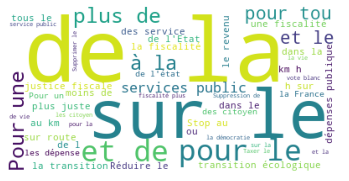

In [146]:
text = ' '.join(df['title'])
wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Ce nuage n'est absolument pas informatif car il ne fait apparaître quasiment que des mots vides de sens (_stopwords_ en anglais), qui se retrouvent dans la plupart des contributions. On va donc essayer de tracer un nouveau nuage en les retirant.

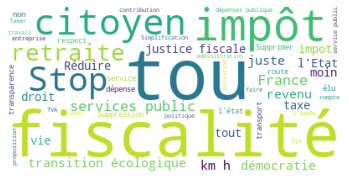

In [147]:
exclure_mots = ['d', 'du', 'de', 'la', 'des', 'le', 'et', 'est', 'elle', 'une', 'en', 'que', 'aux', 'qui', 'ces', 'les', 'dans', 'sur', 'l', 'un', 'pour', 'par', 'il', 'ou', 'à', 'ce', 'a', 'sont', 'cas', 'plus', 'leur', 'se', 's', 'vous', 'au', 'c', 'aussi', 'toutes', 'autre', 'comme']
wordcloud = WordCloud(background_color = 'white', stopwords = exclure_mots, max_words = 50).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

C'est mieux : on retrouve effectivement des mots en lien avec les thématiques abordées par le Grand Débat.

Il peut être intéressant de dessiner un nuage de mots pour chacun des 4 thèmes, afin de se donner rapidement une idée des notions qu'ils recouvrent.

In [148]:
def generate_wordcloud(category):
    text = ' '.join(df.loc[df['categorie'] == category, 'title'])
    wordcloud = WordCloud(background_color = 'white', stopwords = exclure_mots, max_words = 50).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(category)
    plt.show()

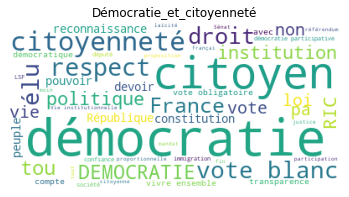

In [149]:
generate_wordcloud("Démocratie_et_citoyenneté")

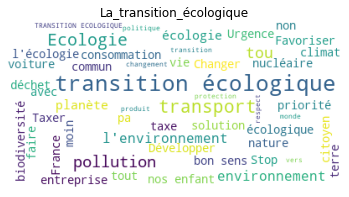

In [150]:
generate_wordcloud("La_transition_écologique")

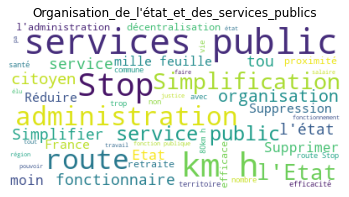

In [151]:
generate_wordcloud("Organisation_de_l'état_et_des_services_publics")

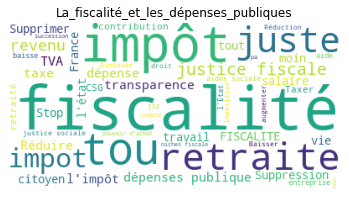

In [152]:
generate_wordcloud("La_fiscalité_et_les_dépenses_publiques")

### Modèle

Essayons de construire un modèle pour classer les contributions dans les 4 thèmes. Dans un premier temps, on va essayer d'effectuer la prédiction uniquement à partir du titre que l'utilisateur à choisi de donner à sa contribution.

#### Prédiction uniquement à partir de l'intitulé de la contribution

On commence par mettre la variable cible au format nécessaire : la chaîne de caractères \_\_label\_\_ suivie de la catégorie. Attention, il ne doit pas y avoir d'espaces.

In [153]:
df['y'] = '__label__' + df['categorie']

In [154]:
df['y'].head(3)

0    __label__Démocratie_et_citoyenneté
1    __label__Démocratie_et_citoyenneté
2    __label__Démocratie_et_citoyenneté
Name: y, dtype: object

On va faire un peu de preprocessing du libellé textuel. Ici, pour l'exemple, on définit une fonction qui retire tous les nombres d'une chaîne de caractères et on l'applique à notre libellé. En effet, les nombres apportent du bruit mais assez peu d'informations à l'algorithme de classification.

Libre à vous d'essayer d'autres traitements et opérations de nettoyage.

In [155]:
def preprocess_for_fasttext(text):
    # remove all numbers
    text = re.sub('[0-9]+', " ", text)
    return text

In [156]:
df['X'] = df['title'].apply(lambda txt : preprocess_for_fasttext(txt))

In [157]:
df['X'].iloc[6]

'Pour plus de démocratie participative'

A présent, on va séparer les données en deux échantillons : 
- un échantillon d'entraînement que l'on va fournir au modèle pour le calibrer,
- un échantillon de test pour évaluer les performances du modèle.

L'échantillon d'entraînement représente 80% des lignes, et l'échantillon de test les 20% restants.

On utilise une graine pour initialiser le générateur de nombres aléatoires, par l'intermédiaire de la variable _random_state_, arbitrairement fixée à 42 ici (tout autre nombre aurait fonctionné). Cette graine permet de rendre le découpage des échantillons déterministe. Sans elle, le découpage serait différent à chaque exécution de la fonction, ce qui ferait fluctuer les performances du modèle.

En plus de cela, on effectue un tirage stratifié, de façon à conserver la même répartition des 4 thèmes entre l'échantillon d'entraînement et l'échantillon de test.

In [158]:
X_train, X_test, y_train, y_test = train_test_split(df['X'], df['y'],
                                                    stratify=df['y'], 
                                                    test_size=0.20,
                                                    random_state = 42)

Le modèle prend en entrée des fichiers texte, on se plie donc à ses désirs.

In [159]:
train_data = list(X_train + " " + y_train)
with open('train_data.txt', 'w') as f:
    for item in train_data:
        f.write("%s\n" % item)
        
test_data = list(X_test + " " + y_test)
with open('test_data.txt', 'w') as f:
    for item in test_data:
        f.write("%s\n" % item)

C'est le moment d'entraîner le modèle ! On utilise l'algorithme ___fastText___. Nul besoin d'en connaître tous les rouages pour pouvoir l'utiliser, mais voici une description en quelques mots pour les curieux. Il contient deux briques principales :
- La première brique consiste à __associer au libellé textuel en entrée__ (ici le titre de la contribution, par exemple "Pour plus de démocratie participative") __un plongement lexical__, c'est-à-dire une représentation numérique sous forme de vecteur tenant compte du sens du libellé. Le modèle associe d'abord un plongement :
     - à chaque mot composant le libellé,
     - mais aussi aux sous-séquences de caractères (appelées n-grammes) de chaque mot (par exemple 'dém', 'émo', 'moc', 'ocr', etc. pour le mot démocratie),
     - ainsi qu'à la combinaison de mots successifs (par exemple 'Pour plus', 'plus de', 'de démocratie' et 'démocratie participative' pour les combinaisons de deux mots).
Puis le plongement du libellé complet est obtenu en prenant la moyenne de tous ces plongements (mots, sous-séquences de caractères, et combinaison de mots).
- La seconde brique est un [classifieur linéaire](https://fr.wikipedia.org/wiki/Classifieur_lin%C3%A9aire) qui __associe au  libellé une probabilité d'appartenir à chaque catégorie__.
Pour classer le libellé, il ne reste plus qu'à sélectionner la catégorie correspondant à la probabilité la plus élevée.

Lorsque l'on entraîne le modèle, on peut faire bouger différents paramètres (liste non exhaustive, plus de détails [ici](https://fasttext.cc/docs/en/python-module.html#train_supervised-parameters) : 
- __epoch__ : nombre de fois que le modèle voit l'ensemble des données (l'apprentissage est un processus itératif)
- __lr__ : learning rate, ou taux d'apprentissage, il détermine la taille du pas dans le processus itératif de minimisation de l'erreur
- __minn__ : longueur minimale des n-grammes de caractères considérés
- __maxn__ : longueur maximale des n-grammes de caractères considérés
- __wordNgrams__ : longueur maximale des combinaisons de mots considérées
- __minCount__ : nombre minimal d'occurrences dans tout le corpus pour qu'un mot soit considéré (et reçoive un plongement lexical)
- __dim__ : dimension de l'espace de plongement lexical, c'est-à-dire la dimension des vecteurs numériques associés aux libellés

Pour plus de détails sur fastText, voici [sa documentation](https://fasttext.cc/docs/en/support.html).

In [160]:
start_time = time.time()
model = fasttext.train_supervised(input="train_data.txt",loss='ova',
                                  epoch=50,lr=.15,wordNgrams=3,minCount=3,
                                  bucket=3000000,minn=3,maxn=6)
print(f"Temps d'exécution total : {(time.time() - start_time):.2f} secondes ---")

Read 3M words
Number of words:  37194
Number of labels: 4
Progress:  99.9% words/sec/thread:   19814 lr:  0.000077 avg.loss:  0.688463 ETA:   0h 0m 0s 24.1% words/sec/thread:   16174 lr:  0.113781 avg.loss:  0.911220 ETA:   0h 2m 3s

Temps d'exécution total : 133.84 secondes ---


Progress: 100.0% words/sec/thread:   19809 lr:  0.000000 avg.loss:  0.688298 ETA:   0h 0m 0s


L'un des avantages de fastText est sa rapidité d'exécution. Il permet d'entraîner des modèles sur de gros corpus de textes en quelques minutes, là où des modèles concurrents mettraient plusieurs heures.

### Analyse des résultats

On peut maintenant évaluer les performances du modèle. Le premier nombre correspond au nombre d'observations, tandis que le deuxième et le troisème correspondent à la proportion d'observations classées correctement. On regarde d'abord les performances sur l'échantillon d'apprentissage.

In [161]:
model.test("train_data.txt")

(455217, 0.926180261281982, 0.926180261281982)

Puis on évalue le modèle en "conditions réelles", sur un échantillon qu'il n'a jamais rencontré. Les performances sont moins bonnes que sur l'échantillon d'entraînement mais restent satisfaisantes.

In [162]:
model.test("test_data.txt")

(113805, 0.7897016827028689, 0.7897016827028689)

On peut rentrer un peu plus dans le détail en affichant la précision, le rappel et le F1-score correspondant à chaque catégorie. Pour la ligne correspondant au thème "transition écologique" par exemple :
- La précision désigne la proportion d'observations bien classées parmi celles que le modèle a classé en transition écologique
- Le rappel désigne la proportion d'observations bien classées parmi celles qui appartiennent effectivement au thème transition écologique
- Le F1-score est une mesure agrégée permettant de combiner la précision et le rappel. Il s'agit de la moyenne harmonique des deux.

Plus de détails sur la précision et le rappel sur [la page Wikipedia correspondante](https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel).

In [163]:
pd.DataFrame(model.test_label("test_data.txt")).T

precision    recall  \
__label__Organisation_de_l'état_et_des_services...   0.709000  0.686392   
__label__Démocratie_et_citoyenneté                   0.733753  0.744487   
__label__La_transition_écologique                    0.858200  0.863305   
__label__La_fiscalité_et_les_dépenses_publiques      0.815091  0.819238   

                                                     f1score  
__label__Organisation_de_l'état_et_des_services...  0.697513  
__label__Démocratie_et_citoyenneté                  0.739081  
__label__La_transition_écologique                   0.860745  
__label__La_fiscalité_et_les_dépenses_publiques     0.817159

### Analyse de l'embedding

On peut se donner une idée un peu plus précise de la façon dont le modèle comprend le langage en explorant le plongement lexial obtenu. Ceci peut se faire de différentes manières. On peut d'abord afficher la représentation numérique d'un mot, mais cela n'est pas très informatif.

In [164]:
model.get_word_vector("environnement")

array([-2.9872611e-02, -5.0982084e-02,  3.1744675e-03,  9.1140635e-02,
       -2.8927941e-02, -3.0077115e-02,  3.5202101e-02,  3.4910955e-02,
       -3.6578376e-02, -9.1524459e-03, -2.8818170e-02,  3.4634974e-02,
        1.2179635e-02,  6.0891759e-02,  1.4887608e-03,  2.5723100e-02,
       -1.9384341e-02,  7.1117140e-02, -5.7999615e-02, -9.3733007e-03,
       -4.9100429e-02,  4.2439472e-02,  2.5695883e-02, -4.7229279e-02,
        1.8804060e-02, -4.5007817e-02,  2.5285727e-03, -4.1995369e-02,
       -1.3746225e-04,  8.9179948e-02,  7.5730355e-03, -7.5323626e-02,
       -4.8852276e-02,  1.9735722e-03, -9.1955312e-02,  3.8995989e-02,
        2.8233195e-02,  6.2986935e-04, -1.1627601e-02, -6.2474869e-02,
        1.8751673e-02,  5.3359039e-02, -4.5889437e-02,  3.1881902e-02,
       -3.9261140e-02,  5.4671140e-03,  3.0170409e-02, -2.8469915e-02,
       -1.4965394e-01,  2.6113624e-02, -1.2003694e-03,  2.6567105e-02,
       -4.8426546e-02,  6.6485882e-02,  1.8867457e-02, -8.1725791e-02,
      

Plus intéressant, on peut visualiser les mots les plus proches d'un mot donné. Par exemple, avec le mot "environnement", excepté toutes les variations d'orthographe, on retrouve des mots proches comme "dérèglement", "pollué" ou encore "climat".

In [165]:
model.get_nearest_neighbors('environnement', k = 30)

[(0.9978631138801575, "'environnement"),
 (0.9975693225860596, "l'environnement"),
 (0.9959995150566101, 'L’environnement'),
 (0.9954587817192078, 'environment'),
 (0.9949905872344971, 'environnements'),
 (0.9942401647567749, "l'environnement..."),
 (0.9938685297966003, "l'environnement,"),
 (0.9936979413032532, 'environnementaux'),
 (0.99337238073349, "l'environnement?"),
 (0.9933006167411804, 'Envirronement'),
 (0.9932168126106262, "d'environnement"),
 (0.9931560754776001, 'environnementales.'),
 (0.9930346012115479, "l'environnement."),
 (0.9929113984107971, 'environnement.'),
 (0.9922611117362976, "d'environnement."),
 (0.9921538829803467, 'l’environnement'),
 (0.9916737675666809, 'environnementaux.'),
 (0.9909996390342712, 'dérèglement'),
 (0.9905297160148621, 'environnement,'),
 (0.9904585480690002, 'environnementale'),
 (0.9903746843338013, "l'environnement!"),
 (0.9901397824287415, 'environnemental,'),
 (0.9899763464927673, 'anti-environnement'),
 (0.9898313283920288, 'Environn

In [166]:
model.get_nearest_neighbors('citoyenneté', k = 30)

[(0.9916607141494751, 'Citoyenneté'),
 (0.9824870824813843, 'citoyenneté,'),
 (0.9808833599090576, 'Cytoyenneté'),
 (0.9796323180198669, 'citoyenneté"'),
 (0.9780408143997192, 'Citoyenneté,'),
 (0.9724134206771851, 'Honneteté'),
 (0.9687294363975525, 'majorite'),
 (0.9684658050537109, 'annonceurs'),
 (0.9683338403701782, 'DEMOCRATIQUES'),
 (0.9679381251335144, 'violente'),
 (0.9674556851387024, 'RIC...'),
 (0.9673811197280884, 'fierté'),
 (0.9673260450363159, 'FRIC'),
 (0.9671197533607483, 'IMMIGRATION'),
 (0.9664645791053772, '"citoyen"'),
 (0.9660197496414185, 'représentants.'),
 (0.9659178853034973, "l'Afrique"),
 (0.9654054641723633, 'non-violence'),
 (0.9652033448219299, 'DEMOCRATIQUE'),
 (0.9648331999778748, 'Confiance,'),
 (0.9646657705307007, 'vote)'),
 (0.964245617389679, 'valeurs'),
 (0.9633792042732239, 'ensemble.'),
 (0.9628481268882751, 'POSSIBILITES'),
 (0.9627206325531006, 'Identité'),
 (0.9626219868659973, 'Reférendum'),
 (0.9624849557876587, 'majorité)'),
 (0.962433159

On peut également observer, pour deux mots donnés, si le modèle considère qu'ils sont proches sémantiquement ou pas. Pour ce faire, on calcule la [similarité cosinus](https://fr.wikipedia.org/wiki/Similarit%C3%A9_cosinus) entre les deux vecteurs. Un score proche de 1 indique que les mots sont proches, et inversement les mots sont très éloignés si leurs score s'approche de -1.

On constate sur quelques exemples que les scores paraissent logiques : "climat" est plus proche de "dérèglement" que de "état", "pollution" est très proche de "air" et moins de "économique".

In [167]:
def fasttext_cosine_similarity(word1, word2):
    return f"Similarité entre {word1} et {word2} : {cosine_similarity([model.get_word_vector(word1)], [model.get_word_vector(word2)])[0][0]}"

In [168]:
print(fasttext_cosine_similarity('climat', 'dérèglement'))
print(fasttext_cosine_similarity('climat', 'état'))

Similarité entre climat et dérèglement : 0.9767272472381592
Similarité entre climat et état : -0.12304826825857162


In [169]:
print(fasttext_cosine_similarity('pollution', 'air'))
print(fasttext_cosine_similarity('pollution', 'économique'))

Similarité entre pollution et air : 0.9424540996551514
Similarité entre pollution et économique : 0.3911677896976471


On peut malgré tout constater des incohérences. Le modèle considère que les mots "animal" et "chien" sont assez éloignés. Comment l'expliquer ? Etant donné les sujets traités par le Grand Débat, il y a probablement assez peu de contributions qui évoquent les animaux, le modèle n'a donc pas pu appendre correctement les plongements lexicaux des mots appartenant à ce domaine.

In [170]:
print(fasttext_cosine_similarity('animal', 'chien'))
print(fasttext_cosine_similarity('animal', 'oiseau'))

Similarité entre animal et chien : -0.3946355879306793
Similarité entre animal et oiseau : 0.7886731624603271


De façon assez intéressante, même des mots qui n'existent pas possèdent un plongement lexical. Ceci est possible parce que fastText traite les n-grammes de caractères et leur associe un plongement lexical. Ainsi, le modèle est capable de dire que les mots "environnement" et "enviroment" (une variation possible du mot "environnement" avec oubli de quelques lettres) sont très proches, alors qu'il n'a jamais rencontré le mot "enviroment" à proprement parler.

__Cela rend le modèle robuste aux fautes de frappe et d'orthographe, ainsi qu'aux petites variations sur les mots__ (pluriel, féminin, conjugaison, etc.). Là où un modèle classique considèrera "démocratie" et "démocratique" comme deux mots différents, fastText saura reconnaître leur proximité.

In [171]:
print(fasttext_cosine_similarity('environnement', 'enviroment'))

Similarité entre environnement et enviroment : 0.9576146602630615


In [172]:
'enviroment' in model #cette instruction renvoie False si le mot proposé n'existe pas dans le corpus

False

### Analyse de quelques erreurs

Il est toujours intéressant de jeter un oeil aux erreurs commises par le modèle, afin d'en comprendre les causes principales.

On fait un peu de formattage pour obtenir la liste des prédictions du modèle et la vraie catégorie côte à côté, de façon à repérer facilement les erreurs.

In [173]:
def format_label(labels):
    return [re.sub('__label__', '', label) for label in labels]

In [174]:
 def build_predictions_df(labels, probs):
    return pd.DataFrame((
        format_label(label) + list(prob)
        for label, prob in zip(labels, probs)
    ), columns=["prediction", "proba"])

In [175]:
domaines, probs = model.predict(list(X_test), k=1)

In [176]:
predictions = build_predictions_df(domaines, probs)

In [177]:
predictions

prediction     proba
0                            Démocratie_et_citoyenneté  0.743178
1               La_fiscalité_et_les_dépenses_publiques  0.988323
2               La_fiscalité_et_les_dépenses_publiques  1.000010
3               La_fiscalité_et_les_dépenses_publiques  0.867046
4                             La_transition_écologique  0.839744
...                                                ...       ...
113800                        La_transition_écologique  0.973251
113801          La_fiscalité_et_les_dépenses_publiques  0.275140
113802  Organisation_de_l'état_et_des_services_publics  0.912446
113803                       Démocratie_et_citoyenneté  0.798197
113804                        La_transition_écologique  0.999300

[113805 rows x 2 columns]

In [178]:
predictions.index = y_test.index
results = pd.concat([y_test, predictions], axis = 1)
results['y'] = format_label(y_test)

In [179]:
results.head(20)

y  \
48849                        Démocratie_et_citoyenneté   
446300          La_fiscalité_et_les_dépenses_publiques   
368882          La_fiscalité_et_les_dépenses_publiques   
296307          La_fiscalité_et_les_dépenses_publiques   
222543                        La_transition_écologique   
104925                       Démocratie_et_citoyenneté   
520859  Organisation_de_l'état_et_des_services_publics   
511788  Organisation_de_l'état_et_des_services_publics   
490723  Organisation_de_l'état_et_des_services_publics   
423258          La_fiscalité_et_les_dépenses_publiques   
465551  Organisation_de_l'état_et_des_services_publics   
246730                        La_transition_écologique   
326700          La_fiscalité_et_les_dépenses_publiques   
457215  Organisation_de_l'état_et_des_services_publics   
366594          La_fiscalité_et_les_dépenses_publiques   
269206                        La_transition_écologique   
150021                        La_transition_écologique   
390205          La_fiscalité_et_les_dépenses_publiques   
31770                        Démocratie_et_citoyenneté   
547025  Organisation_de_l'état_et_des_services_publics   

                                            prediction     proba  
48849                        Démocratie_et_citoyenneté  0.743178  
446300          La_fiscalité_et_les_dépenses_publiques  0.988323  
368882          La_fiscalité_et_les_dépenses_publiques  1.000010  
296307          La_fiscalité_et_les_dépenses_publiques  0.867046  
222543                        La_transition_écologique  0.839744  
104925                       Démocratie_et_citoyenneté  0.793116  
520859  Organisation_de_l'état_et_des_services_publics  0.999384  
511788  Organisation_de_l'état_et_des_services_publics  0.754925  
490723                       Démocratie_et_citoyenneté  0.348655  
423258          La_fiscalité_et_les_dépenses_publiques  0.996186  
465551  Organisation_de_l'état_et_des_services_publics  0.334599  
246730                        La_transition_écologique  1.000010  
326700          La_fiscalité_et_les_dépenses_publiques  0.899131  
457215  Organisation_de_l'état_et_des_services_publics  0.991163  
366594          La_fiscalité_et_les_dépenses_publiques  0.803184  
269206                        La_transition_écologique  0.996527  
150021                        La_transition_écologique  0.985946  
390205          La_fiscalité_et_les_dépenses_publiques  0.976321  
31770                        Démocratie_et_citoyenneté  1.000010  
547025  Organisation_de_l'état_et_des_services_publics  0.994455

In [180]:
results[results['y'] != results['prediction']].head()

y  \
490723  Organisation_de_l'état_et_des_services_publics   
304799          La_fiscalité_et_les_dépenses_publiques   
509878  Organisation_de_l'état_et_des_services_publics   
522565  Organisation_de_l'état_et_des_services_publics   
67598                        Démocratie_et_citoyenneté   

                                            prediction     proba  
490723                       Démocratie_et_citoyenneté  0.348655  
304799                        La_transition_écologique  0.874087  
509878          La_fiscalité_et_les_dépenses_publiques  0.953976  
522565          La_fiscalité_et_les_dépenses_publiques  0.712242  
67598   Organisation_de_l'état_et_des_services_publics  0.859674

Quelques exemples d'erreurs commises par le modèle. Les indices correspondent à ceux du tableau ci-dessus.

Ici, le modèle est assez incertain. Il penche vers le thème Démocratie et citoyenneté, sans doute en raison de la référence à la nationalité française et de la notion d'expatriation. Concrètement, avec un tel libellé, difficile même pour un humain de savoir à quel thème la contribution appartient.

In [109]:
X_test[490723]

"DE L'ART D'INCITER LES FRANÇAIS A S'EXPATRIER"

Ici, le titre choisi est poétique, mais peu informatif sur le contenu de la contribution. Le modèle a choisi la transition écologique, sans doute à cause de l'évocation d'élements naturels ("ruisseaux" et "rivières").

In [110]:
X_test[304799]

'Petits ruisseaux font de grandes rivières'

Ici c'est probablement la notion d'aide qui fait pencher le modèle vers le thème de la fiscalité et des dépenses publiques plutôt que celui de l'organisation de l'état, malgré la présence du mot "état" lui-même dans le titre.

In [111]:
X_test[509878]

"Aide médicale d'état AME"

Un titre totalement vide de sens et sur lequel le modèle ne pouvait absolument rien faire.

In [112]:
X_test[522565]

'Ma participation perso à moi'

#### Prédiction à partir du texte des réponses à toutes les questions

Puisque le titre de la contribution ne contient pas toujours suffisamment d'informations, essayons de résoudre le même problème, mais en utilisant maintenant le texte des réponses aux questions à la place du titre. Le libellé est maintenant bien plus long.

In [182]:
df['libelle'].iloc[6]

"Pour plus de démocratie participative ? Oui Toutes Plus de réunions publiques en laissant vraiment la parole aux citoyens. Une bonne chose Les responsabilités doivent être partagées. Une dose de vote  proportionnel. Oui suppression du Sénat. Elle est trop faible car les citoyens n'y croient plus. Plus de démocratie participative pour les impliquer davantage. Oui Qu'il soit considéré comme un vote exprimé. En commençant par l'échelon municipal. Oui ? ? ?                    Développer la démocratie participative en commençant par  l’échelon municipal. Que tout projet soit soumis à la population avant d’être voté. Organiser plus de réunions publiques en laissant la parole aux habitants."

On procède aux mêmes étapes que précédemment pour entraîner le modèle.

In [183]:
X_train, X_test, y_train, y_test = train_test_split(df['libelle'], df['y'],
                                                    stratify=df['y'], 
                                                    test_size=0.20,
                                                    random_state = 42)

In [184]:
train_data = list(X_train + " " + y_train)
with open('train_data.txt', 'w') as f:
    for item in train_data:
        f.write("%s\n" % item)
        
test_data = list(X_test + " " + y_test)
with open('test_data.txt', 'w') as f:
    for item in test_data:
        f.write("%s\n" % item)

Il y a maintenant beaucoup plus de données à traiter, l'entraînement du modèle prend presque 1h au lieu de 2-3 minutes.

In [185]:
start_time = time.time()
model = fasttext.train_supervised(input="train_data.txt",loss='ova',
                                  epoch=25,lr=.15,wordNgrams=3,minCount=3,
                                  bucket=3000000,minn=3,maxn=6)
print(f"Temps d'exécution total : {(time.time() - start_time):.2f} secondes ---")

Read 139M words
Number of words:  505513
Number of labels: 4
Progress: 100.0% words/sec/thread:   19766 lr:  0.000006 avg.loss:  0.028979 ETA:   0h 0m 0s  0.6% words/sec/thread:   13877 lr:  0.149139 avg.loss:  1.332535 ETA:   0h58m39s  1.7% words/sec/thread:   14584 lr:  0.147379 avg.loss:  0.541712 ETA:   0h55m 9s  2.2% words/sec/thread:   14774 lr:  0.146651 avg.loss:  0.447269 ETA:   0h54m10s  2.4% words/sec/thread:   14797 lr:  0.146424 avg.loss:  0.426974 ETA:   0h54m 0s 0.143789 avg.loss:  0.281694 ETA:   0h52m26s 17.9% words/sec/thread:   17662 lr:  0.123102 avg.loss:  0.094644 ETA:   0h38m 2s 27.3% words/sec/thread:   18366 lr:  0.109011 avg.loss:  0.070763 ETA:   0h32m23s 29.1% words/sec/thread:   18468 lr:  0.106295 avg.loss:  0.067300 ETA:   0h31m24s 33.5% words/sec/thread:   18714 lr:  0.099816 avg.loss:  0.060728 ETA:   0h29m 6s% words/sec/thread:   18775 lr:  0.097704 avg.loss:  0.059610 ETA:   0h28m24s 36.2% words/sec/thread:   18828 lr:  0.095694 avg.loss:  0.058069 ET

Temps d'exécution total : 2501.37 secondes ---


Progress: 100.0% words/sec/thread:   19766 lr:  0.000000 avg.loss:  0.028977 ETA:   0h 0m 0s


In [187]:
model.test("train_data.txt")

(455217, 0.9995408783063902, 0.9995408783063902)

La tâche est effectivement beaucoup plus facile en utilisant le texte de l'ensemble de la contribution. Le modèle n'est pas loin d'un sans faute !

In [188]:
model.test("test_data.txt")

(113805, 0.9984007732524933, 0.9984007732524933)

In [189]:
pd.DataFrame(model.test_label("test_data.txt")).T

precision    recall  \
__label__Organisation_de_l'état_et_des_services...   0.998615  0.998169   
__label__Démocratie_et_citoyenneté                   0.997683  0.997683   
__label__La_transition_écologique                    0.998667  0.998570   
__label__La_fiscalité_et_les_dépenses_publiques      0.998501  0.998848   

                                                     f1score  
__label__Organisation_de_l'état_et_des_services...  0.998392  
__label__Démocratie_et_citoyenneté                  0.997683  
__label__La_transition_écologique                   0.998618  
__label__La_fiscalité_et_les_dépenses_publiques     0.998675

## Tâche 2 : Classer les réponses à une question

L'objectif ici est de considérer une seule question ouverte et de classer les réponses à cette question dans des catégories.  Les catégories sont issues des données de [la Grande Annotation](https://grandeannotation.fr/), initiative au cours de laquelle plus de 1000 personnes ont lu des réponses et les ont classées par domaine en fonction de ce qui y était proposé.

Voici la liste de quelques questions en rapport avec la transition écologique, ainsi que le code numérique associé pour faire le lien entre les données du Grand Débat et celles de la Grande Annotation. Pour l'exemple, nous allons classer les réponses de la question 147 : "Si oui, de quelle manière votre vie quotidienne est-elle touchée par le changement climatique ?". Celle-ci faisait suite à la question fermée 146 : "Diriez-vous que votre vie quotidienne est aujourd'hui touchée par le changement climatique ?"

### Chargement des données

In [3]:
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'})

In [52]:
with fs.open(f"s3://projet-funathon/Sujet7-fastText_grand_debat/LA_TRANSITION_ECOLOGIQUE.csv", 'rb') as f:
    df_ecologie = pd.read_csv(f)

/tmp/ipykernel_901/1984863267.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ecologie = pd.read_csv(f)


In [53]:
with fs.open(f"s3://projet-funathon/Sujet7-fastText_grand_debat/grande_annotation.csv", 'rb') as f:
    df_annot = pd.read_csv(f)

In [54]:
df_ecologie.head()

id reference  \
0  UHJvcG9zYWw6ZmZlN2MwNzktMWUyMC0xMWU5LTk0ZDItZm...       2-4   
1  UHJvcG9zYWw6M2RmZmUxZjMtMWUyMS0xMWU5LTk0ZDItZm...       2-5   
2  UHJvcG9zYWw6NDg1YWUxYjItMWUyMS0xMWU5LTk0ZDItZm...       2-6   
3  UHJvcG9zYWw6NTk2Nzk5MmItMWUyMS0xMWU5LTk0ZDItZm...       2-7   
4  UHJvcG9zYWw6ODU5NWMyOTYtMWUyMS0xMWU5LTk0ZDItZm...       2-8   

                   title            createdAt          publishedAt updatedAt  \
0  transition écologique  2019-01-22 09:37:49  2019-01-22 09:37:49       NaN   
1       La surpopulation  2019-01-22 09:39:33  2019-01-22 09:39:33       NaN   
2                 climat  2019-01-22 09:39:50  2019-01-22 09:39:50       NaN   
3      POLLUTION AIR EAU  2019-01-22 09:40:19  2019-01-22 09:40:19       NaN   
4   Economie vs Ecologie  2019-01-22 09:41:33  2019-01-22 09:41:33       NaN   

   trashed trashedStatus                                           authorId  \
0    False           NaN  VXNlcjoxMTQwMTc0YS0xZTFmLTExZTktOTRkMi1mYTE2M2...   
1    False           NaN  VXNlcjpjOWYxZWQ1NS0xYzEwLTExZTktOTRkMi1mYTE2M2...   
2    False           NaN  VXNlcjozZjlhNzAwOS0xYTc2LTExZTktOTRkMi1mYTE2M2...   
3    False           NaN  VXNlcjozOWQwNzJjNC0xZDEwLTExZTktOTRkMi1mYTE2M2...   
4    False           NaN  VXNlcjo3M2YxN2NlZS0xZDRiLTExZTktOTRkMi1mYTE2M2...   

            authorType  ...  \
0  Citoyen / Citoyenne  ...   
1  Citoyen / Citoyenne  ...   
2  Citoyen / Citoyenne  ...   
3  Citoyen / Citoyenne  ...   
4  Citoyen / Citoyenne  ...   

   QUXVlc3Rpb246MTUw - Qu'est-ce qui pourrait vous inciter à changer vos comportements comme par exemple mieux entretenir et régler votre chauffage, modifier votre manière de conduire ou renoncer à prendre votre véhicule pour de très petites distances ?  \
0                                                NaN                                                                                                                                                                                                            
1                                                NaN                                                                                                                                                                                                            
2             développer  les transports en commun ,                                                                                                                                                                                                            
3                                                NaN                                                                                                                                                                                                            
4  Aménagement de piste cyclable, développement d...                                                                                                                                                                                                            

  QUXVlc3Rpb246MTUx - Quelles seraient pour vous les solutions les plus simples et les plus supportables sur un plan financier pour vous inciter à changer vos comportements ?  \
0                                                NaN                                                                                                                             
1                                                NaN                                                                                                                             
2                                                NaN                                                                                                                             
3  Plus de transports publics dans les petites co...                                                                                                                             
4  Détaxer le mode de chauffage écologique, une a...                         

Les données de la Grande Annotation contiennent une variable "Poids". Celle-ci vise à corriger certains biais découlant d'un mécanisme d'annotation automatique des textes identiques : lorsqu'un utilisateur annote une réponse et qu'il existe d'autres réponses identiques, ces dernières sont annotées automatiquement. Explications détaillées [ici](https://github.com/fm89/granddebat/blob/master/doc/MATH.md).

Par simplicité, nous n'allons pas utiliser cette variable ici.

In [57]:
df_annot.head()

Debat Contribution  Question                                Categorie  \
0      1          1-8       107  Sans réponse / Hors sujet / Inclassable   
1      1         1-15       107               Président de la République   
2      1         1-16       107                              Y Mensonges   
3      1         1-16       107                    Y Politique de métier   
4      1         1-18       107                            Tous les élus   

      Poids  
0  1.005227  
1  1.009220  
2  5.840523  
3  5.840523  
4  3.193653

### Preprocessing

On récupère les réponses à la question qui nous intéresse, et on renomme colonne pour rendre les choses plus lisibles.

In [55]:
df_ecologie = df_ecologie[['reference', "QUXVlc3Rpb246MTQ3 - Si oui, de quelle manière votre vie quotidienne est-elle touchée par le changement climatique ?"]].copy()
df_ecologie.rename(columns={"reference": "Contribution", "QUXVlc3Rpb246MTQ3 - Si oui, de quelle manière votre vie quotidienne est-elle touchée par le changement climatique ?": "reponse"}, inplace = True)

In [56]:
df_ecologie.head()

Contribution                                            reponse
0          2-4                                                NaN
1          2-5                                                NaN
2          2-6                                                NaN
3          2-7                                                NaN
4          2-8  Pollution de l'air, pollution de nos aliments,...

Ensuite, on récupère les annotations correspondant à la question traitée.

In [58]:
df_annot = df_annot.loc[df_annot['Question'] == 147]
df_annot = df_annot[['Contribution', 'Categorie']]

On peut observer les catégories qui ont été identifiées, ainsi que la répartition des réponses. C'est assez déséquilibré.

Par ailleurs, il faut noter également que seul un petit échantillon de réponses ont pu être annotées. Ici on va travailler avec quelques milliers de réponses, soit un jeu de données beaucoup plus réduit que dans la première tâche de ce notebook. Il y a également plus de catégories. Ce sont des points à prendre en compte dans l'analyse des résultats du modèle.

In [59]:
df_annot['Categorie'].value_counts()

Pollution (air, eau, sol)                                           1469
Evénements extrêmes (incendie, inondation, sécheresse, tempêtes)    1137
Saisons modifiées, déréglées                                        1016
Canicule, nécessité de la clim                                       810
Maladies, santé                                                      654
Modification de l'environnement (biodiversité, paysage)              596
Impact financier                                                     149
Manque d'eau                                                          95
Sans réponse / Hors sujet / Inclassable                               87
Z Je ne suis pas touché                                               86
Impact psychologique                                                  85
Z Autres                                                              83
Effort écolo                                                          67
Arrivée de migrants climatiques                    

On fusionne les deux jeux de données.

In [61]:
df = pd.merge(df_ecologie, df_annot, on = "Contribution")

In [62]:
df.head()

Contribution                                            reponse  Debat  \
0         2-12                                             Climat      2   
1         2-19                   les catastrophes et la pollution      2   
2         2-19                   les catastrophes et la pollution      2   
3         2-45  Ce n'est pas la meilleurs façon de poser la qu...      2   
4         2-47  Migration de population due au réchauffement c...      2   

   Question                                          Categorie      Poids  
0       147                       Saisons modifiées, déréglées   1.604898  
1       147  Evénements extrêmes (incendie, inondation, séc...  22.027965  
2       147                          Pollution (air, eau, sol)  22.027965  
3       147            Sans réponse / Hors sujet / Inclassable  22.027965  
4       147                    Arrivée de migrants climatiques  22.027965

On retire les réponses vides.

In [70]:
df.dropna(subset = 'reponse', inplace = True)

### Modèle

Le code pour préparer les données et entraîner le modèle est très similaire à celui de la tâche précédente.

In [83]:
df['y'] = '__label__' + df['Categorie'].str.replace(' ', '_')

In [74]:
def preprocess_for_fasttext(text):
    # remove all numbers
    text = re.sub('[0-9]+', " ", text)
    return text

In [76]:
df['X'] = df['reponse'].apply(lambda txt : preprocess_for_fasttext(txt))

In [77]:
df['reponse'].iloc[6]

"Il n'y a plus de saisons."

In [85]:
X_train, X_test, y_train, y_test = train_test_split(df['X'], df['y'],
                                                    stratify=df['y'], 
                                                    test_size=0.20,
                                                    random_state = 42)

In [86]:
train_data = list(X_train + " " + y_train)
with open('train_data.txt', 'w') as f:
    for item in train_data:
        f.write("%s\n" % item)
        
test_data = list(X_test + " " + y_test)
with open('test_data.txt', 'w') as f:
    for item in test_data:
        f.write("%s\n" % item)

In [87]:
start_time = time.time()
model = fasttext.train_supervised(input="train_data.txt",loss='ova',
                                  epoch=50,lr=.15,wordNgrams=3,minCount=3,
                                  bucket=3000000,minn=3,maxn=6)
print(f"Temps d'exécution total : {(time.time() - start_time):.2f} secondes ---")

Read 0M words
Number of words:  3526
Number of labels: 17
Progress:  99.7% words/sec/thread:   20664 lr:  0.000498 avg.loss:  1.501667 ETA:   0h 0m 0s 78.5% words/sec/thread:   20444 lr:  0.032243 avg.loss:  1.580963 ETA:   0h 0m 0s

Temps d'exécution total : 4.97 secondes ---


Progress: 100.0% words/sec/thread:   20221 lr:  0.000000 avg.loss:  1.502495 ETA:   0h 0m 0s


In [88]:
model.test("train_data.txt")

(5139, 0.7215411558669002, 0.7215411558669002)

In [89]:
model.test("test_data.txt")

(1285, 0.5478599221789884, 0.5478599221789884)

Les performances sont moyennes, mais avec peu de données et un nombre assez élevé de catégories différentes, le modèle ne s'en sort pas si mal.

In [90]:
pd.DataFrame(model.test_label("test_data.txt")).T

precision    recall  \
__label__Idée_marquée                                     NaN       NaN   
__label__Z_Je_ne_suis_pas_touché                     0.571429  0.705882   
__label__Hausse_du_niveau_des_mers                        NaN  0.000000   
__label__Canicule,_nécessité_de_la_clim              0.570513  0.549383   
__label__Evénements_extrêmes_(incendie,_inondat...   0.465909  0.541850   
__label__Modification_de_l'environnement_(biodi...   0.319444  0.386555   
__label__Maladies,_santé                             0.641791  0.656489   
__label__Chauffage_l'hiver                                NaN  0.000000   
__label__Saisons_modifiées,_déréglées                0.569231  0.546798   
__label__Impact_financier                            0.400000  0.400000   
__label__Manque_d'eau                                     NaN  0.000000   
__label__Impact_psychologique                        0.500000  0.058824   
__label__Pollution_(air,_eau,_sol)                   0.669782  0.731293   
__label__Z_Autres                                         NaN  0.000000   
__label__Sans_réponse_/_Hors_sujet_/_Inclassable     0.500000  0.529412   
__label__Arrivée_de_migrants_climatiques                  NaN  0.000000   
__label__Effort_écolo                                     NaN  0.000000   

                                                     f1score  
__label__Idée_marquée                                    NaN  
__label__Z_Je_ne_suis_pas_touché                    0.631579  
__label__Hausse_du_niveau_des_mers                  0.000000  
__label__Canicule,_nécessité_de_la_clim             0.559748  
__label__Evénements_extrêmes_(incendie,_inondat...  0.501018  
__label__Modification_de_l'environnement_(biodi...  0.349810  
__label__Maladies,_santé                            0.649057  
__label__Chauffage_l'hiver                          0.000000  
__label__Saisons_modifiées,_déréglées               0.557789  
__label__Impact_financier                           0.400000  
__label__Manque_d'eau                               0.000000  
__label__Impact_psychologique                       0.105263  
__label__Pollution_(air,_eau,_sol)                  0.699187  
__label__Z_Autres                                   0.000000  
__label__Sans_réponse_/_Hors_sujet_/_Inclassable    0.514286  
__label__Arrivée_de_migrants_climatiques            0.000000  
__label__Effort_écolo                               0.000000

## Comment poursuivre ?

- Essayer de classer les réponses d'une autre question ouverte (tâche 2)
- Ajouter des étapes de prétraitements des libellés (suppression des stop words, [lemmatisation](https://fr.wikipedia.org/wiki/Lemmatisation), etc.)
- Faire varier les paramètres d'entraînement du modèle pour tenter d'améliorer les performances
- Explorer le plongement lexical obtenu